# Objective

Twitter has become an important channel of conveying information, specially when it’s related to disasters and natural calamities. While most people are truthful some people and organizations may try to spread fake news. So in this project we will try to classify the news as real or fake. 
The dataset provided was by Kaggle, as a part of a competition. The data set has 3 Files:

1. train.csv - the training set

2. test.csv - the test set

3. sample_submission.csv - a sample submission file in the correct format

Columns:

1. id - a unique identifier for each tweet

2. text - the text of the tweet

3. location - the location the tweet was sent from (may be blank)

4. keyword - a particular keyword from the tweet (may be blank)

5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

We will do Data Wrangling and EDA on this data set and then use NLP techniques and many machine learning models to predict whether the tweet is real or fake. We will also check the accuracy of each model used.  

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import re
import nltk
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Exploratory Data Analysis

In [2]:
traindf = pd.read_csv("../input/nlp-getting-started/train.csv")
testdf = pd.read_csv("../input/nlp-getting-started/test.csv")

In [3]:
keywords = traindf['keyword'].value_counts()
keywords

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [4]:
px.scatter(keywords, x=keywords.values , y=keywords.index, size=keywords.values)

In [5]:
location = traindf['location'].value_counts()
px.scatter(location, y=location.values, x=location.index,size=location.values)

In [6]:
print(" Null values in location column: ",traindf['location'].isnull().sum())

 Null values in location column:  2533


In [7]:
print(" Null values in location column: ",traindf['keyword'].isnull().sum())

 Null values in location column:  61


In [8]:
# Calculate percentage of missing keywords_
print('{}% of Kewords are missing from Total Number of Records'.format(round(((traindf['location'].isnull().sum() + traindf['keyword'].isnull().sum())/len(traindf.index))*100)))

34.0% of Kewords are missing from Total Number of Records


## Dropping unwanted column - "location"

In [9]:
#dropping unwanted column 'location'
traindf.drop(['location'],axis=1,inplace= True)
testdf=testdf.drop(['location'],axis=1)
traindf.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Removing NA values

In [10]:
#dropping missing 'keyword' records from train data set

traindf.dropna(axis=0,inplace= True)
print("Number of records after removing missing keywords", len(traindf.index))

Number of records after removing missing keywords 7552


## Creating a Corpus

In [11]:
corpus  = [] 
stemmer = PorterStemmer()
for i in traindf['text']:
    
    #Remove unwanted letters in the tweets 
    
    text = re.sub("[^a-zA-Z]", ' ', i)
    
    #Transform words to lowercase and splitting them to form a list
    
    text = text.lower()
    
    text = text.split()
    
    #Remove stopwords then stemming it i.e removing the different types of the same words and replacing by a single type.
    
    text = [stemmer.stem(word) for word in text if not word in set(stopwords.words('english'))]
    
    text = ' '.join(text)
    
    #Append cleaned tweet to corpus
    
    corpus.append(text)
    
print("Corpus created successfully")  

Corpus created successfully


In [12]:
#Creating a table of unique words and their count. 
uniqueWords = {}

for text in corpus:  
    
    for word in text.split():
        
        if(word in uniqueWords.keys()):
            
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
            
#Convert the dictionary to dataFrame

uniqueWords = pd.DataFrame.from_dict(uniqueWords,orient='index',columns=['WordFrequency'])
uniqueWords.sort_values(by=['WordFrequency'], inplace=True, ascending=False)

print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))


uniqueWords.head(10)

Number of records in Unique Words Data frame are 18849


,WordFrequency
co,4722
http,4697
like,410
fire,358
amp,344
get,310
bomb,237
new,228
via,219
u,216


In [13]:
print("Max count of a word is: ", uniqueWords['WordFrequency'].max())
print("Min count of a word is: ", uniqueWords['WordFrequency'].min())
print("Mean count of a word is: ", uniqueWords['WordFrequency'].mean())

Max count of a word is:  4722
Min count of a word is:  1
Mean count of a word is:  4.646665605602419


In [14]:
uniqueWords=uniqueWords[uniqueWords['WordFrequency']>=20]
print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))

Number of records in Unique Words Data frame are 781


(-0.5, 399.5, 199.5, -0.5)

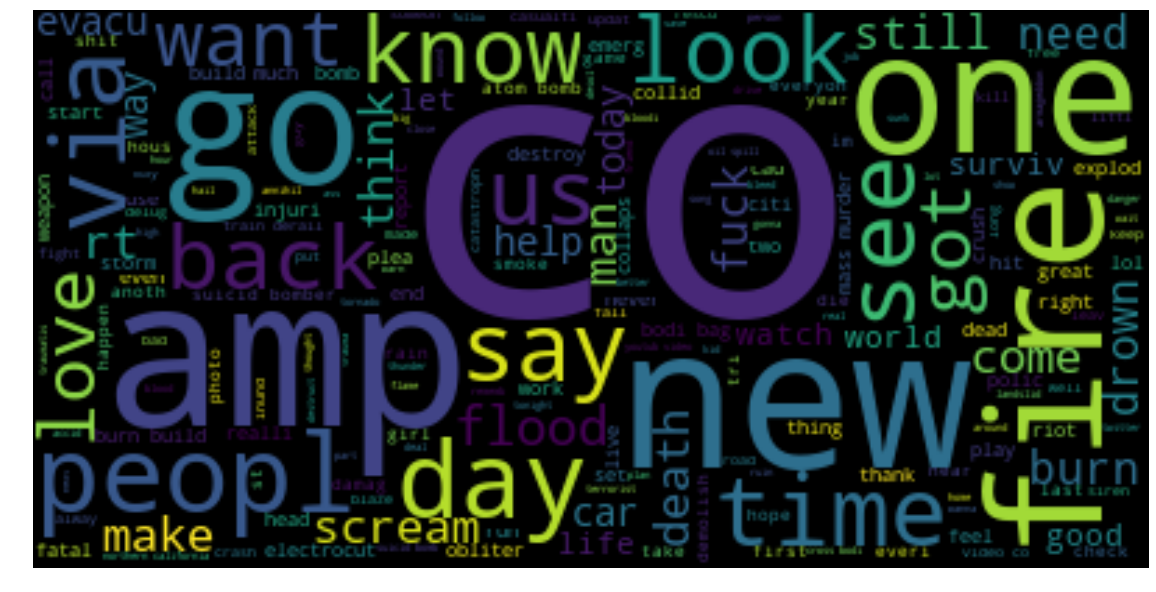

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(corpus))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

## Creating a Bag of words model

In [16]:
cv = CountVectorizer(max_features = len(uniqueWords))
#Create Bag of Words Model, here X represent bag of words
X = cv.fit_transform(corpus).todense()
y = traindf['target'].values

In [17]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3)
print('Train Data splitted successfully')

Train Data splitted successfully


# Fitting models and predicting accuracy

## Gaussian Naive Bayes

In [18]:
classifier_gnb = GaussianNB()

classifier_gnb.fit(X_train, y_train)

predgnb = classifier_gnb.predict(X_test)

In [19]:
print(confusion_matrix(y_test, predgnb))
print(classification_report(y_test, predgnb))

[[1182  104]
 [ 444  536]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1286
           1       0.84      0.55      0.66       980

    accuracy                           0.76      2266
   macro avg       0.78      0.73      0.74      2266
weighted avg       0.77      0.76      0.75      2266



## Gradient Boosting

In [20]:
classifier_gb = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.01,n_estimators = 100,max_depth = 30, random_state=55)
classifier_gb.fit(X_train, y_train)
predgb = classifier_gb.predict(X_test)

In [21]:
print(confusion_matrix(y_test, predgb))
print(classification_report(y_test, predgb))

[[1204   82]
 [ 472  508]]
              precision    recall  f1-score   support

           0       0.72      0.94      0.81      1286
           1       0.86      0.52      0.65       980

    accuracy                           0.76      2266
   macro avg       0.79      0.73      0.73      2266
weighted avg       0.78      0.76      0.74      2266



## K-Nearest Neighbours

In [22]:
classifier_knn = KNeighborsClassifier(n_neighbors = 7,weights = 'distance',algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
predknn = classifier_knn.predict(X_test)

In [23]:
print(confusion_matrix(y_test, predknn))
print(classification_report(y_test, predknn))

[[1199   87]
 [ 557  423]]
              precision    recall  f1-score   support

           0       0.68      0.93      0.79      1286
           1       0.83      0.43      0.57       980

    accuracy                           0.72      2266
   macro avg       0.76      0.68      0.68      2266
weighted avg       0.75      0.72      0.69      2266



## Decision Tree Models

In [24]:
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
preddt = classifier_dt.predict(X_test)

In [25]:
print(confusion_matrix(y_test, preddt))
print(classification_report(y_test, preddt))

[[1042  244]
 [ 329  651]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1286
           1       0.73      0.66      0.69       980

    accuracy                           0.75      2266
   macro avg       0.74      0.74      0.74      2266
weighted avg       0.75      0.75      0.75      2266



## Logistic Regression

In [26]:

classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)
predlr = classifier_lr.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [27]:
print(confusion_matrix(y_test, predlr))
print(classification_report(y_test, predlr))

[[1132  154]
 [ 299  681]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1286
           1       0.82      0.69      0.75       980

    accuracy                           0.80      2266
   macro avg       0.80      0.79      0.79      2266
weighted avg       0.80      0.80      0.80      2266



## XGBoost

In [28]:
classifier_xgb = XGBClassifier(max_depth=6,learning_rate=0.3,n_estimators=1500,objective='binary:logistic',random_state=123,n_jobs=4)
classifier_xgb.fit(X_train, y_train)
predxgb = classifier_xgb.predict(X_test)

In [29]:
print(confusion_matrix(y_test, predxgb))
print(classification_report(y_test, predxgb))

[[1083  203]
 [ 278  702]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1286
           1       0.78      0.72      0.74       980

    accuracy                           0.79      2266
   macro avg       0.79      0.78      0.78      2266
weighted avg       0.79      0.79      0.79      2266



## Multinomial Naive Bayes

In [30]:
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train, y_train)
predmnb = classifier_mnb.predict(X_test)

In [31]:
print(confusion_matrix(y_test, predmnb))
print(classification_report(y_test, predmnb))

[[1105  181]
 [ 293  687]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1286
           1       0.79      0.70      0.74       980

    accuracy                           0.79      2266
   macro avg       0.79      0.78      0.78      2266
weighted avg       0.79      0.79      0.79      2266



## Artificial Neural Network

In [32]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

classifier_nn = Sequential()
classifier_nn.add(Dense(units=30,activation='relu'))
classifier_nn.add(Dropout(0.5))

classifier_nn.add(Dense(units=15,activation='relu'))
classifier_nn.add(Dropout(0.5))

classifier_nn.add(Dense(units=1,activation='sigmoid'))
classifier_nn.compile(loss='binary_crossentropy', optimizer='adam')

classifier_nn.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 5286 samples, validate on 2266 samples
Epoch 1/600
5286/5286 [==============================] - 2s 385us/sample - loss: 0.6744 - val_loss: 0.6274
Epoch 2/600
5286/5286 [==============================] - 1s 154us/sample - loss: 0.5877 - val_loss: 0.5077
Epoch 3/600
5286/5286 [==============================] - 1s 170us/sample - loss: 0.5115 - val_loss: 0.4594
Epoch 4/600
5286/5286 [==============================] - 1s 144us/sample - loss: 0.4694 - val_loss: 0.4483
Epoch 5/600
5286/5286 [==============================] - 1s 140us/sample - loss: 0.4324 - val_loss: 0.4444
Epoch 6/600
5286/5286 [==============================] - 1s 194us/sample - loss: 0.4079 - val_loss: 0.4462
Epoch 7/600
5286/5286 [==============================] - 1s 115us/sample - loss: 0.3870 - val_loss: 0.4522
Epoch 00007: early stopping


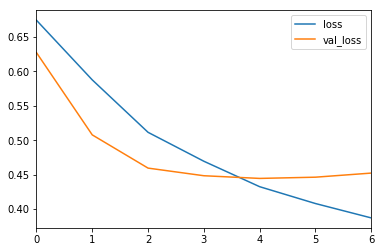

In [33]:
losses = pd.DataFrame(classifier_nn.history.history)
losses[['loss','val_loss']].plot()

In [34]:
prednn = classifier_nn.predict_classes(X_test)

In [35]:
print(confusion_matrix(y_test, prednn))
print(classification_report(y_test, prednn))

[[1133  153]
 [ 297  683]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1286
           1       0.82      0.70      0.75       980

    accuracy                           0.80      2266
   macro avg       0.80      0.79      0.79      2266
weighted avg       0.80      0.80      0.80      2266



# Test Set

In [36]:
print("Number of records present in Test Data Set are: ",len(testdf.index))

print("Number of records without keywords in Test Data are: ",len(testdf[pd.isnull(testdf['keyword'])]))

Number of records present in Test Data Set are:  3263
Number of records without keywords in Test Data are:  26


In [37]:
X_testset=cv.transform(testdf['text']).todense() #Count Vectorising

## Getting Predictions from all the models

In [38]:
y_test_pred_gnb = classifier_gnb.predict(X_testset)
y_test_pred_gb = classifier_gb.predict(X_testset)
y_test_pred_dt = classifier_dt.predict(X_testset)
y_test_pred_knn = classifier_knn.predict(X_testset)
y_test_pred_lr = classifier_lr.predict(X_testset)
y_test_pred_xgb = classifier_xgb.predict(X_testset)
y_test_pred_mnb = classifier_mnb.predict(X_testset)
y_test_pred_nn = classifier_nn.predict_classes(X_testset)

In [39]:
#Fetching Id to differnt frame
y_test_id=testdf[['id']]

#Converting Id into array
y_test_id=y_test_id.values

#Converting 2 dimensional y_test_id into single dimension 
y_test_id=y_test_id.ravel()

In [40]:
#Converting 2 dimensional y_test_pred for all predicted results into single dimension 
y_test_pred_gnb=y_test_pred_gnb.ravel()
y_test_pred_gb=y_test_pred_gb.ravel()
y_test_pred_dt=y_test_pred_dt.ravel()
y_test_pred_knn=y_test_pred_knn.ravel()
y_test_pred_lr=y_test_pred_lr.ravel()
y_test_pred_xgb=y_test_pred_xgb.ravel()
y_test_pred_mnb=y_test_pred_mnb.ravel()
y_test_pred_nn=y_test_pred_nn.ravel()

In [41]:
#Creating Submission dataframe
submission_df_gnb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_gnb})
submission_df_gb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_gb})
submission_df_dt=pd.DataFrame({"id":y_test_id,"target":y_test_pred_dt})
submission_df_knn=pd.DataFrame({"id":y_test_id,"target":y_test_pred_knn})
submission_df_lr=pd.DataFrame({"id":y_test_id,"target":y_test_pred_lr})
submission_df_xgb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_xgb})
submission_df_mnb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_mnb})
submission_df_nn=pd.DataFrame({"id":y_test_id,"target":y_test_pred_nn})



#Setting index as Id Column
submission_df_gnb.set_index("id")
submission_df_gb.set_index("id")
submission_df_dt.set_index("id")
submission_df_knn.set_index("id")
submission_df_lr.set_index("id")
submission_df_xgb.set_index("id")
submission_df_mnb.set_index("id")

,target
id,
0,1
2,0
3,1
9,0
11,1
...,...
10861,0
10865,0
10868,1


## Saving the submissions file

In [42]:
submission_df_gnb.to_csv("submission_gnb.csv",index=False)
submission_df_gb.to_csv("submission_gb.csv",index=False)
submission_df_dt.to_csv("submission_dt.csv",index=False)
submission_df_knn.to_csv("submission_knn.csv",index=False)
submission_df_lr.to_csv("submission_lr.csv",index=False)
submission_df_xgb.to_csv("submission_xgb.csv",index=False)
submission_df_mnb.to_csv("submission_mnb.csv",index=False)
submission_df_nn.to_csv("submission_nn.csv",index=False)

Apart from all this, I decided to look up the internet for the dataset given as input to see if I can find any useful information related and gain more insights into the problem and the data. Look what I found.  

In [43]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
gt_df = pd.read_csv("../input/supplementary-data-set/socialmedia-disaster-tweets-DFE.csv")

In [44]:
gt_df = gt_df[['choose_one', 'text']]
gt_df['target'] = (gt_df['choose_one']=='Relevant').astype(int)
gt_df['id'] = gt_df.index
gt_df

,choose_one,text,target,id
0,Relevant,Just happened a terrible car crash,1,0
1,Relevant,Our Deeds are the Reason of this #earthquake M...,1,1
2,Relevant,"Heard about #earthquake is different cities, s...",1,2
3,Relevant,"there is a forest fire at spot pond, geese are...",1,3
4,Relevant,Forest fire near La Ronge Sask. Canada,1,4
...,...,...,...,...
10871,Relevant,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,10871
10872,Relevant,Police investigating after an e-bike collided ...,1,10872
10873,Relevant,The Latest: More Homes Razed by Northern Calif...,1,10873
10874,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...,1,10874


In [45]:
merged_df = pd.merge(test_df, gt_df, on='id')
merged_df

,id,keyword,location,text_x,choose_one,text_y,target
0,0,NaN,NaN,Just happened a terrible car crash,Relevant,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Relevant,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",Relevant,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Relevant,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Relevant,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,Not Relevant,EARTHQUAKE SAFETY LOS ANGELES ‰ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Relevant,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Relevant,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [46]:
subm_df = merged_df[['id', 'target']]
subm_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [47]:
subm_df.to_csv('submission.csv', index=False)